# Assignment 1: Portfolio Optimization
## Arshdeep Singh Bamrah Course: MIE1622

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex
import matplotlib.pyplot as plt

import cvxpy as cp

### Rounding procedure for the calculated number of assest

In [2]:
def rounder(x): #parts of the code are from https://stackoverflow.com/questions/53201470/how-to-always-round-up-a-xx-5-in-numpy
    if (x-int(x) >= 0.5): #round the asset up if the secoond decimal place is equal or greater that 0.5
        return np.ceil(x)
    else: 
        return np.floor(x) #round the asset down otherwise
rounder_vec = np.vectorize(rounder) #vectorize to apply the function to every value in array

### Buy and hold portfolio

In [3]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
   x_optimal = x_init
   cash_optimal = cash_init
   return x_optimal, cash_optimal

### Equally Weighted portfolio

In [4]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    #compute current portfolio value
    V_cur = np.dot(cur_prices, x_init) 
    w = 1/len(x_init) #weights to be equal amoung all assets for equally weighted strategy
    x_optimal, cash_optimal = rebalance(cur_prices, x_init, w, cash_init) #applying rebalancing algorithim to balance and 
                                                                          #optimize the number of stocks and cash account balance.
    return x_optimal, cash_optimal

### Minimum variance portfolio

\begin{equation}
\begin{array}{rl}
\displaystyle \min_{w} & w^TQw \\
{\rm s.t.} & \sum_i w_i = 1\\
& w \geq 0
\end{array}
\end{equation}

In [5]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    np.random.seed(978351)
    
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize) #setting cplex to minimize
    n = len(x_init)
    c  = [0.0] * n #no linear part in the equation
    lb = [0.0] * n # w>= 0
    ub = [1.0] * n #upper bound = 1
    
    A = [] #LHS of the constraints 
    for k in range(n):
        A.append([[0, 1],[1.0, 0]])
    
    var_names = ["w_%s" % i for i in range(1,n+1)] #total number of variables
    
    cpx.linear_constraints.add(rhs=[1.0, 0], senses="EG") #RHS of the constraints
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names) #adding the linear part of the equation into the solver
    
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)] #defining the quadratic part of the equations
    
    
    cpx.objective.set_quadratic(Qmat) #adding the quadratic part of the solver
    
    cpx.parameters.threads.set(4)
    
    # Disable CPLEX output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    # Compute min varuabce solution with CPLEX
    cpx.solve()
    w_cur = cpx.solution.get_values()
      
    x_optimal, cash_optimal = rebalance(cur_prices, x_init, w_cur, cash_init)#applying rebalancing algorithim to balance and 
                                                                          #optimize the number of stocks and cash account balance.
    
    return x_optimal, cash_optimal

### Maximum Sharpe Ratio portfolio

\begin{equation}
 \begin{array}{rll}
  \displaystyle \min_{y,k} & y^T Q y \\
  \mbox{s.t.} & \sum_{i=1}^n (mu_i - r_f)y_i = 1 \\
  & \sum_{i=1}^n y_i = K \\
  & l \cdot k \leq Ay \leq u \cdot k \\
  & k \geq 0
 \end{array}
\end{equation}

In [6]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    np.random.seed(978351)
    
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize) #setting cplex to minimize
    n = len(x_init)
    c  = [0.0] * 21 #no linear part on the equation
    lb = [0.0] * 21 # k>= 0
    ub = [math.inf] * 21 #upper bound = infinity
    
    #LHS of the constraints 
    Atilde = []
 
    for k in range(n):
        Atilde.append([[0, 1, 2+k],[(mu[k]-(0.025/252)), 1.0, 1.0]])
    Atilde.append([[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],[0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]])
    #adding additonal column for calculating kappa
    
    #RHS of the constraints
    u_tilde = []
    u_tilde = [0.0] * (n+2)
    u_tilde[0] = 1.0 # sum((mu_i-rf)*y) = 1.0
    u_tilde[1] = 0.0 # sum(y_i) = k

    #Setting up the conditions for each constraints
    my_sense    = "EE" + "L" * n
    
    var_names = ["y_%s" % i for i in range(1, n+2)] #total number of variables additonal 1 due to kappa
    
 
    cpx.linear_constraints.add(rhs=u_tilde, senses=my_sense) #RHS of the constraints
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=Atilde, names=var_names) #adding the linear part of the equation into the solver
    
    
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)] #defining the quadratic part of the equations
    
    for k in range(n): #additonal addtional row and column for kappa
        Qmat.append([[0],[0.0]])
        
    cpx.objective.set_quadratic(Qmat) #adding the quadratic part of the solver
    
    cpx.parameters.threads.set(4)
    
    # Disable CPLEX output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    # Compute max sharpe ratio solution with CPLEX
    cpx.solve()
    y = cpx.solution.get_values()
    
    kapa = y[-1] #kapa is the last element of the solution as per the equation setup
    yl = y[:-1] #first 20 elements are the solution for y
    yl = np.asarray(yl)
    
    w_new = yl/kapa #w = y/kappa as per lecture slides
    
    x_optimal, cash_optimal = rebalance(cur_prices, x_init, w_new, cash_init)#applying rebalancing algorithim to balance and 
                                                                          #optimize the number of stocks and cash account balance.

    return x_optimal, cash_optimal


### Buy and hold with Equally Weighted portfolio (additional strategy as per part 3 of the assignment)

In [7]:
def strat_buy_and_hold_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    V_cur = np.dot(cur_prices, x_init) #calculating current value
    W_new = np.asarray(1/len(x_init))  #equally weighted assets
    
    #calculate number of stocks to buy and sell
    new_x = np.divide(np.multiply(V_cur,W_new), cur_prices)
    new_x = rounder_vec(new_x) #applying rounding 
    
    x_optimal = new_x #equally weighted stocks
    cash_optimal = cash_init #no change in cash account as per the assignment
    
    return x_optimal, cash_optimal

In [8]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

In [9]:
# Read data into a dataframe
df = pd.read_csv(input_file_prices)

In [10]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

In [11]:
dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])

In [12]:
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

In [13]:
Q.shape

(20, 20)

In [14]:
# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

In [15]:
# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

In [16]:
# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))


Initial portfolio value = $ 1000012.93



In [17]:
# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

In [18]:
# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

In [19]:
# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025

In [20]:
# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_buy_and_hold_equally_weighted']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Buy and Hold with Equally Weighted']
#N_strat = 4  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_buy_and_hold_equally_weighted]

### Rebalancing Algorithm

In [21]:
#rebalance
def rebalance(todayprice, old_x, W_new, Cash_old):
    Cash=False
    
    #compute current portfolio value
    V_cur = np.dot(todayprice, old_x)
    W_new = np.asarray(W_new)   
    #calculate number of stocks to buy and sell
    new_x = np.divide(np.multiply(V_cur,W_new), todayprice)
    new_x = rounder_vec(new_x) #round up or down up when first decimal is 0.5 or above and round down otherwise
    
    #rebalancing loop
    while Cash==False:
        #calculate buy or sell
        change_x = np.subtract(new_x, old_x) #if positive means buy if negative means sell
        tran_buyl = []
        tran_selll = []
        for i in change_x:
            if i>=0: #making a list of all the stocks which are to buy
                tran_buyl.append(1)
                tran_selll.append(0)
            if i<0: #making a list of all the stocks which are to sell
                tran_buyl.append(0)
                tran_selll.append(1)
        tran_buyl =  np.asarray(tran_buyl) #list with value 1 are to buy stocks
        tran_selll =  np.asarray(tran_selll) #list with value 1 are to sell stocks
        
        tran_buy = np.sum(new_x * tran_buyl * todayprice) * 0.005 #total transaction cost for buy the stocks
        tran_sell = np.sum(new_x * tran_selll * todayprice) * 0.005 #total transaction cost for sell the stocks
        
        Newvalue = np.dot(new_x, todayprice) + tran_buy - tran_sell #total value of the portfolio adding buying cost and subtracting sell cost
              
        Cash_new = V_cur - Newvalue + Cash_old #balancing equation (current portfolio value - new portfolio value + cash account)
        
        #balacing the cash account so its never below zero
        
        if Cash_new >= 0: #if cash account positive then break the rebalancing loop and return the cash and x optimal
            Cash == True
            break
         
        if Cash_new < 0: #if cash negative then recalculate x optimal
            newlist = np.multiply(new_x, todayprice) - abs(Cash_new).tolist() #which stock has a value more than the cash account
            idx_list = np.array(newlist).argsort().tolist() #listing the stocks index in a ascending order
            
            for i in idx_list: #checking the stock value by lowest to highest
                if newlist[i] > 0: #if the stock value is above zero and very close to cash account balance then remove that stock
                    new_x[i] = new_x[i] - 1 #removing the stock which has a close value to the abs(negative cash value). Minimizing the impact on the overall portfolio
                    break
                                                
    return new_x, Cash_new


### Portfolio Calculation main function

In [22]:
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
startdate = []
enddate = []
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 20:
        cur_year  = 20 + math.floor(period/7)
    else:
        cur_year  = 2020 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
    
    startdate.append(day_ind_start)
    enddate.append(day_ind_end)
    

   # Prices for the current day
    cur_prices = data_prices[day_ind_start,:] 

   # Execute portfolio selection strategies
    for strategy  in range(N_strat):

      # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]

      # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
       
      #Verify that strategy is feasible (you have enough budget to re-balance portfolio): See function rebalance
      #Check that cash account is >= 0: See function rebalance
      #Check that we can buy new portfolio subject to transaction costs: See function rebalance

        print(' "{0}" Cash Account Balance = $ {1:.2f}'.format(strategy_names[strategy], cash[strategy, period-1]))  
      # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
        
      
   # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)


Period 1: start date 01/02/2020, end date 02/28/2020
 "Buy and Hold" Cash Account Balance = $ 0.00
Strategy "Buy and Hold", value begin = $ 1000012.93, value end = $ 893956.75
 "Equally Weighted Portfolio" Cash Account Balance = $ 1299.04
Strategy "Equally Weighted Portfolio", value begin = $ 995541.53, value end = $ 896756.50
 "Mininum Variance Portfolio" Cash Account Balance = $ 13.18
Strategy "Mininum Variance Portfolio", value begin = $ 997732.95, value end = $ 920767.15
 "Maximum Sharpe Ratio Portfolio" Cash Account Balance = $ 37.53
Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 995037.92, value end = $ 926807.47
 "Buy and Hold with Equally Weighted" Cash Account Balance = $ 0.00
Strategy "Buy and Hold with Equally Weighted", value begin = $ 999936.51, value end = $ 901108.71

Period 2: start date 03/02/2020, end date 04/30/2020
 "Buy and Hold" Cash Account Balance = $ 0.00
Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
 "Equally Weighted

 "Mininum Variance Portfolio" Cash Account Balance = $ 28.92
Strategy "Mininum Variance Portfolio", value begin = $ 1100245.01, value end = $ 1076432.15
 "Maximum Sharpe Ratio Portfolio" Cash Account Balance = $ 78.10
Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 2199422.93, value end = $ 2242701.59
 "Buy and Hold with Equally Weighted" Cash Account Balance = $ 0.00
Strategy "Buy and Hold with Equally Weighted", value begin = $ 1535539.12, value end = $ 1586167.25

Period 12: start date 11/01/2021, end date 12/31/2021
 "Buy and Hold" Cash Account Balance = $ 0.00
Strategy "Buy and Hold", value begin = $ 951350.41, value end = $ 932471.35
 "Equally Weighted Portfolio" Cash Account Balance = $ 301.90
Strategy "Equally Weighted Portfolio", value begin = $ 1587016.77, value end = $ 1648927.24
 "Mininum Variance Portfolio" Cash Account Balance = $ 1709.13
Strategy "Mininum Variance Portfolio", value begin = $ 1077404.22, value end = $ 1071449.45
 "Maximum Sharpe Ratio Portfolio

### Plotting Results

In [23]:
# Plot results
###################### Insert your code here ############################

In [24]:
periods = [0,1,2,3,4,5,6,7,8,9,10,11]


In [25]:
#function to calculate the daily value of the portfolio given the strategy 
def daily_value(startdate, enddate, periods, cash, data_prices, dates, strategy=0):
    g = np.array([])
    da = np.array([])
    for s,e,p,c in zip(startdate, enddate, periods, cash[strategy]):
        d = np.dot(data_prices[s:e], x[strategy][p]) + c
        g = np.hstack((g,d))
        da = np.hstack((da,dates[s:e]))
    return(da, g)

In [26]:
#daily value each strategy
Dates1, Buy_hold = daily_value(startdate, enddate, periods, cash, data_prices, dates, strategy=0)
Dates1, Eq_weight = daily_value(startdate, enddate, periods, cash, data_prices, dates, strategy=1)
Dates1, Min_var = daily_value(startdate, enddate, periods, cash, data_prices, dates, strategy=2)
Dates1, Max_sharpe = daily_value(startdate, enddate, periods, cash, data_prices, dates, strategy=3)
Dates1, Buy_hod_Eq_Weght = daily_value(startdate, enddate, periods, cash, data_prices, dates, strategy=4)

In [27]:
#creating a dataframe contatining the daily portfolio value for each strategy 

da_valuedf = pd.DataFrame(index = Dates1) 
da_valuedf['Buy_hold'] = Buy_hold
da_valuedf['Eq_weight'] = Eq_weight
da_valuedf['Min_var'] = Min_var
da_valuedf['Max_sharpe'] = Max_sharpe
da_valuedf['Buy_hod_Eq_Weght'] = Buy_hod_Eq_Weght

In [28]:
da_valuedf

,Buy_hold,Eq_weight,Min_var,Max_sharpe,Buy_hod_Eq_Weght
01/02/2020,1.000013e+06,9.955415e+05,9.977330e+05,9.950379e+05,9.999365e+05
01/03/2020,9.890027e+05,9.826210e+05,9.863916e+05,9.821269e+05,9.869469e+05
01/06/2020,9.871785e+05,9.859736e+05,9.907731e+05,9.897207e+05,9.903832e+05
01/07/2020,9.760961e+05,9.838300e+05,9.900858e+05,9.927003e+05,9.882515e+05
01/08/2020,9.782858e+05,9.893090e+05,9.966079e+05,1.002073e+06,9.936859e+05
...,...,...,...,...,...
12/23/2021,9.436135e+05,1.644687e+06,1.074383e+06,2.296430e+06,1.666034e+06
12/27/2021,9.437578e+05,1.669497e+06,1.080892e+06,2.346114e+06,1.691216e+06
12/28/2021,9.452071e+05,1.667451e+06,1.084379e+06,2.342646e+06,1.689144e+06
12/29/2021,9.391084e+05,1.660650e+06,1.078453e+06,2.333796e+06,1.682267e+06


Text(0, 0.5, 'Value $ (In Millions)')

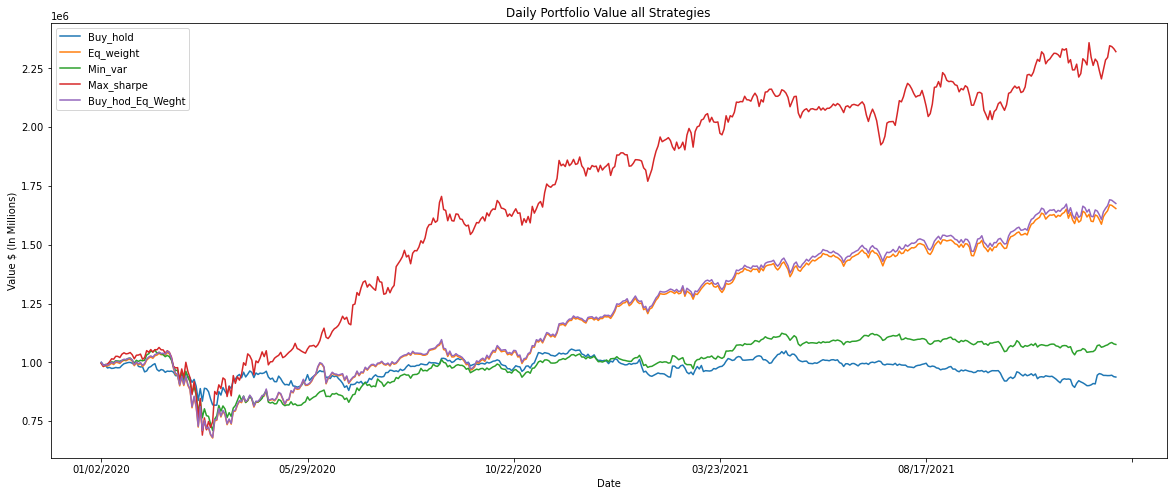

In [29]:
#Showing all strategies in one chart 
da_valuedf.plot.line(figsize = (20,8))
plt.title('Daily Portfolio Value all Strategies')
plt.xlabel('Date')
plt.ylabel('Value $ (In Millions)')

Text(0, 0.5, 'Value $ (In Millions)')

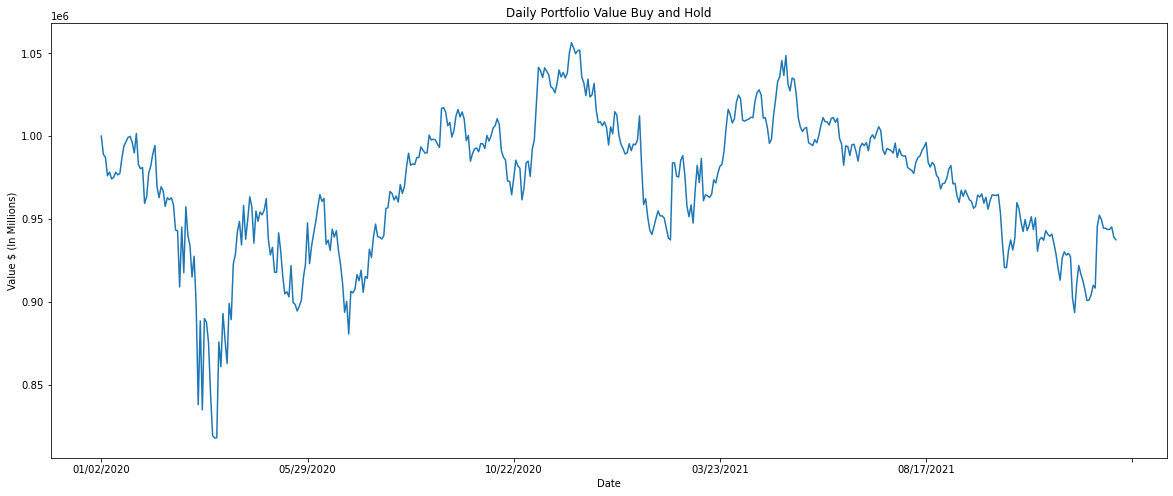

In [30]:
#daily Value Buy and hold strategy
fig, ax = plt.subplots(figsize = (20,8))
da_valuedf['Buy_hold'].plot.line()
plt.title('Daily Portfolio Value Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Value $ (In Millions)')

Text(0, 0.5, 'Value $ (In Millions)')

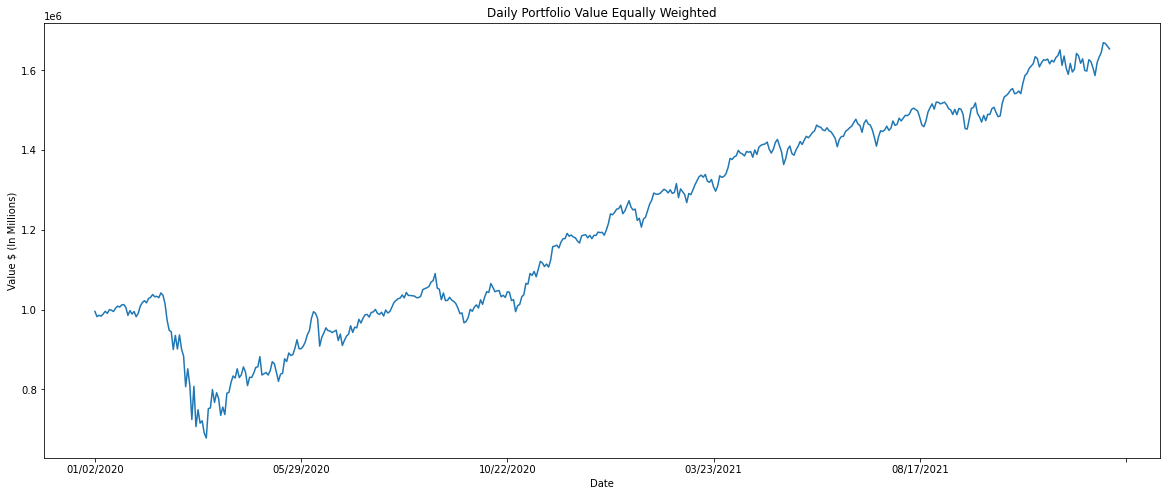

In [31]:
#daily Value Equally Weighted strategy
fig, ax = plt.subplots(figsize = (20,8))
da_valuedf['Eq_weight'].plot.line()
plt.title('Daily Portfolio Value Equally Weighted')
plt.xlabel('Date')
plt.ylabel('Value $ (In Millions)')

Text(0, 0.5, 'Value $ (In Millions)')

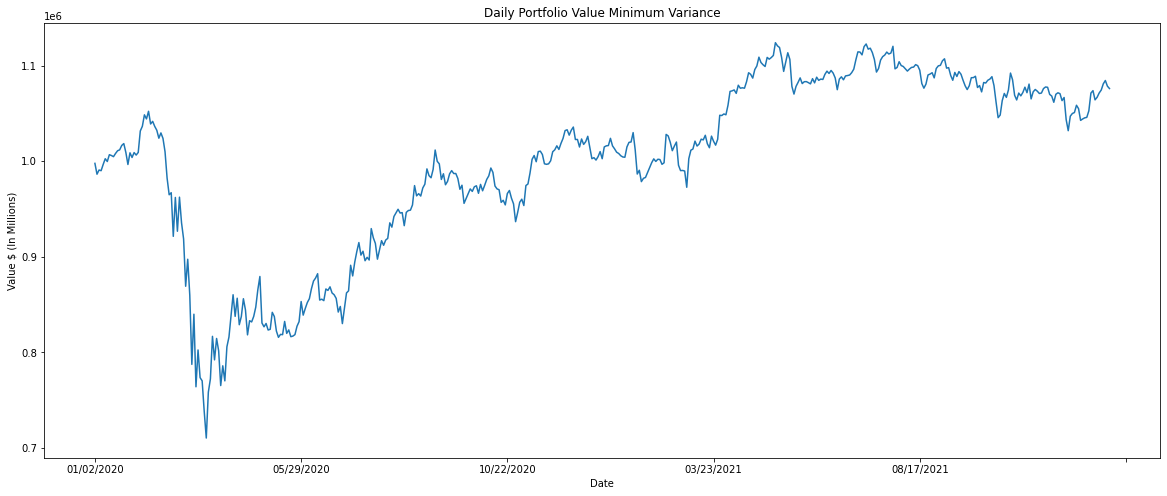

In [32]:
#daily Value Minimum Variance strategy
fig, ax = plt.subplots(figsize = (20,8))
da_valuedf['Min_var'].plot.line()
plt.title('Daily Portfolio Value Minimum Variance')
plt.xlabel('Date')
plt.ylabel('Value $ (In Millions)')

Text(0, 0.5, 'Value $ (In Millions)')

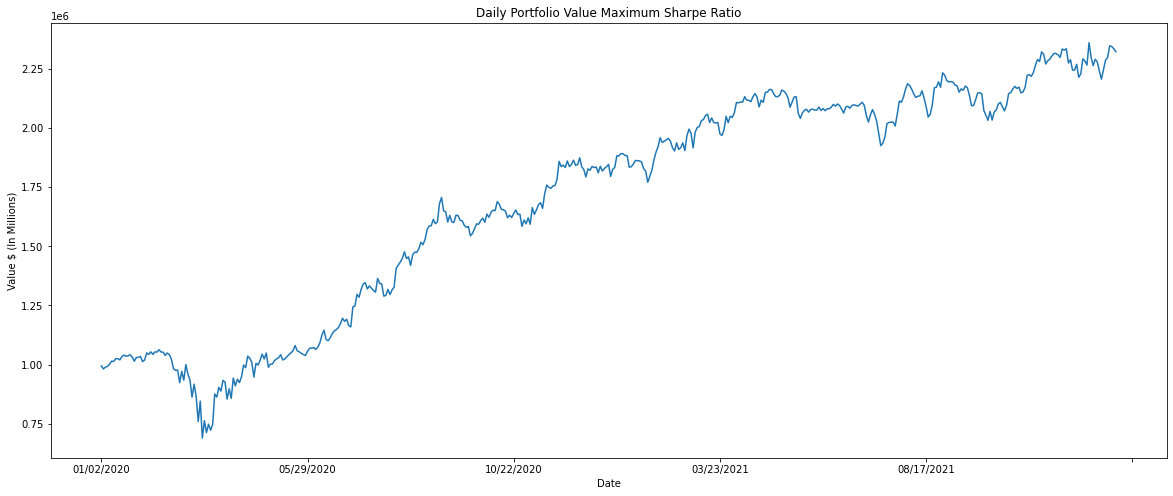

In [33]:
#daily Value Maximum Sharpe Ratio strategy
fig, ax = plt.subplots(figsize = (20,8))
da_valuedf['Max_sharpe'].plot.line()
plt.title('Daily Portfolio Value Maximum Sharpe Ratio')
plt.xlabel('Date')
plt.ylabel('Value $ (In Millions)')

In [34]:
#Function to calculate the dynamic weight change based on the daily value of each strategy
def dynamic_change(startdate, enddate, periods, cash, data_prices, dates, strategy=0):
    g = np.empty(shape=[0, 20])
    da = np.array([])
    for s,e,p,c in zip(startdate, enddate, periods, cash[strategy]): 
        j = np.dot(data_prices[s:e], x[strategy][p]) + c
        d = np.divide((np.multiply(data_prices[s:e], x[strategy][p])), j.reshape(-1,1))
        g = np.vstack((g,d))
        da = np.hstack((da,dates[s:e]))
    return(da, g)

In [35]:
#calculating dynamic change in the weights for Min variance and Max Sharpe ratio strategies
Dates1, Min_var_weights = dynamic_change(startdate, enddate, periods, cash, data_prices, dates, strategy=2)
Dates1, Max_sharpe_weight = dynamic_change(startdate, enddate, periods, cash, data_prices, dates, strategy=3)

In [36]:
da_valuedf3 = pd.DataFrame(Min_var_weights, columns = list(df.columns)[1:], index = Dates1)
da_valuedf4 = pd.DataFrame(Max_sharpe_weight, columns = list(df.columns)[1:], index = Dates1)

Text(0, 0.5, 'Asset Weights')

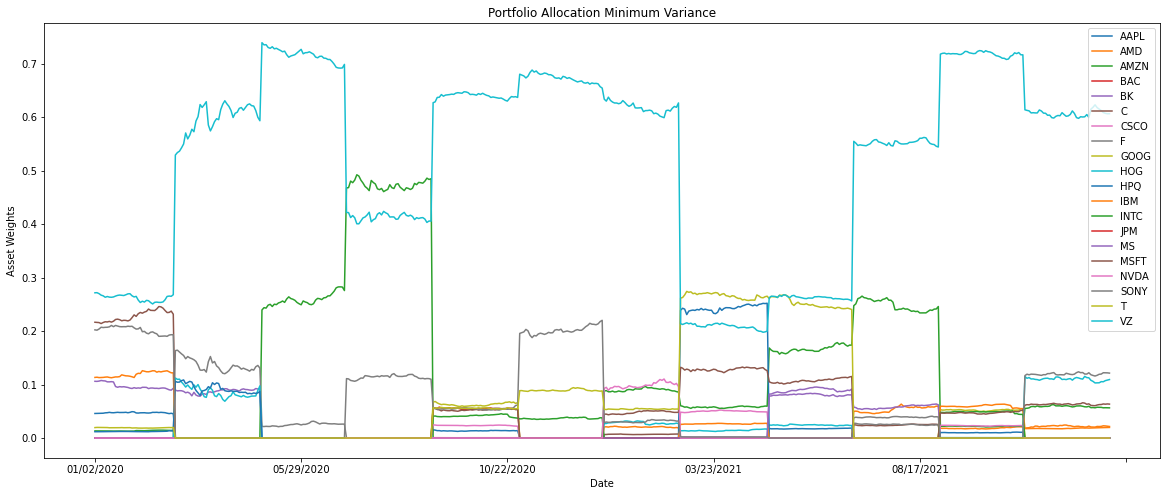

In [37]:
#ploting the chart showing Portfolio Allocation for Minimum variance Strategy
da_valuedf3.plot.line(figsize = (20,8))
plt.title('Portfolio Allocation Minimum Variance')
plt.xlabel('Date')
plt.ylabel('Asset Weights')

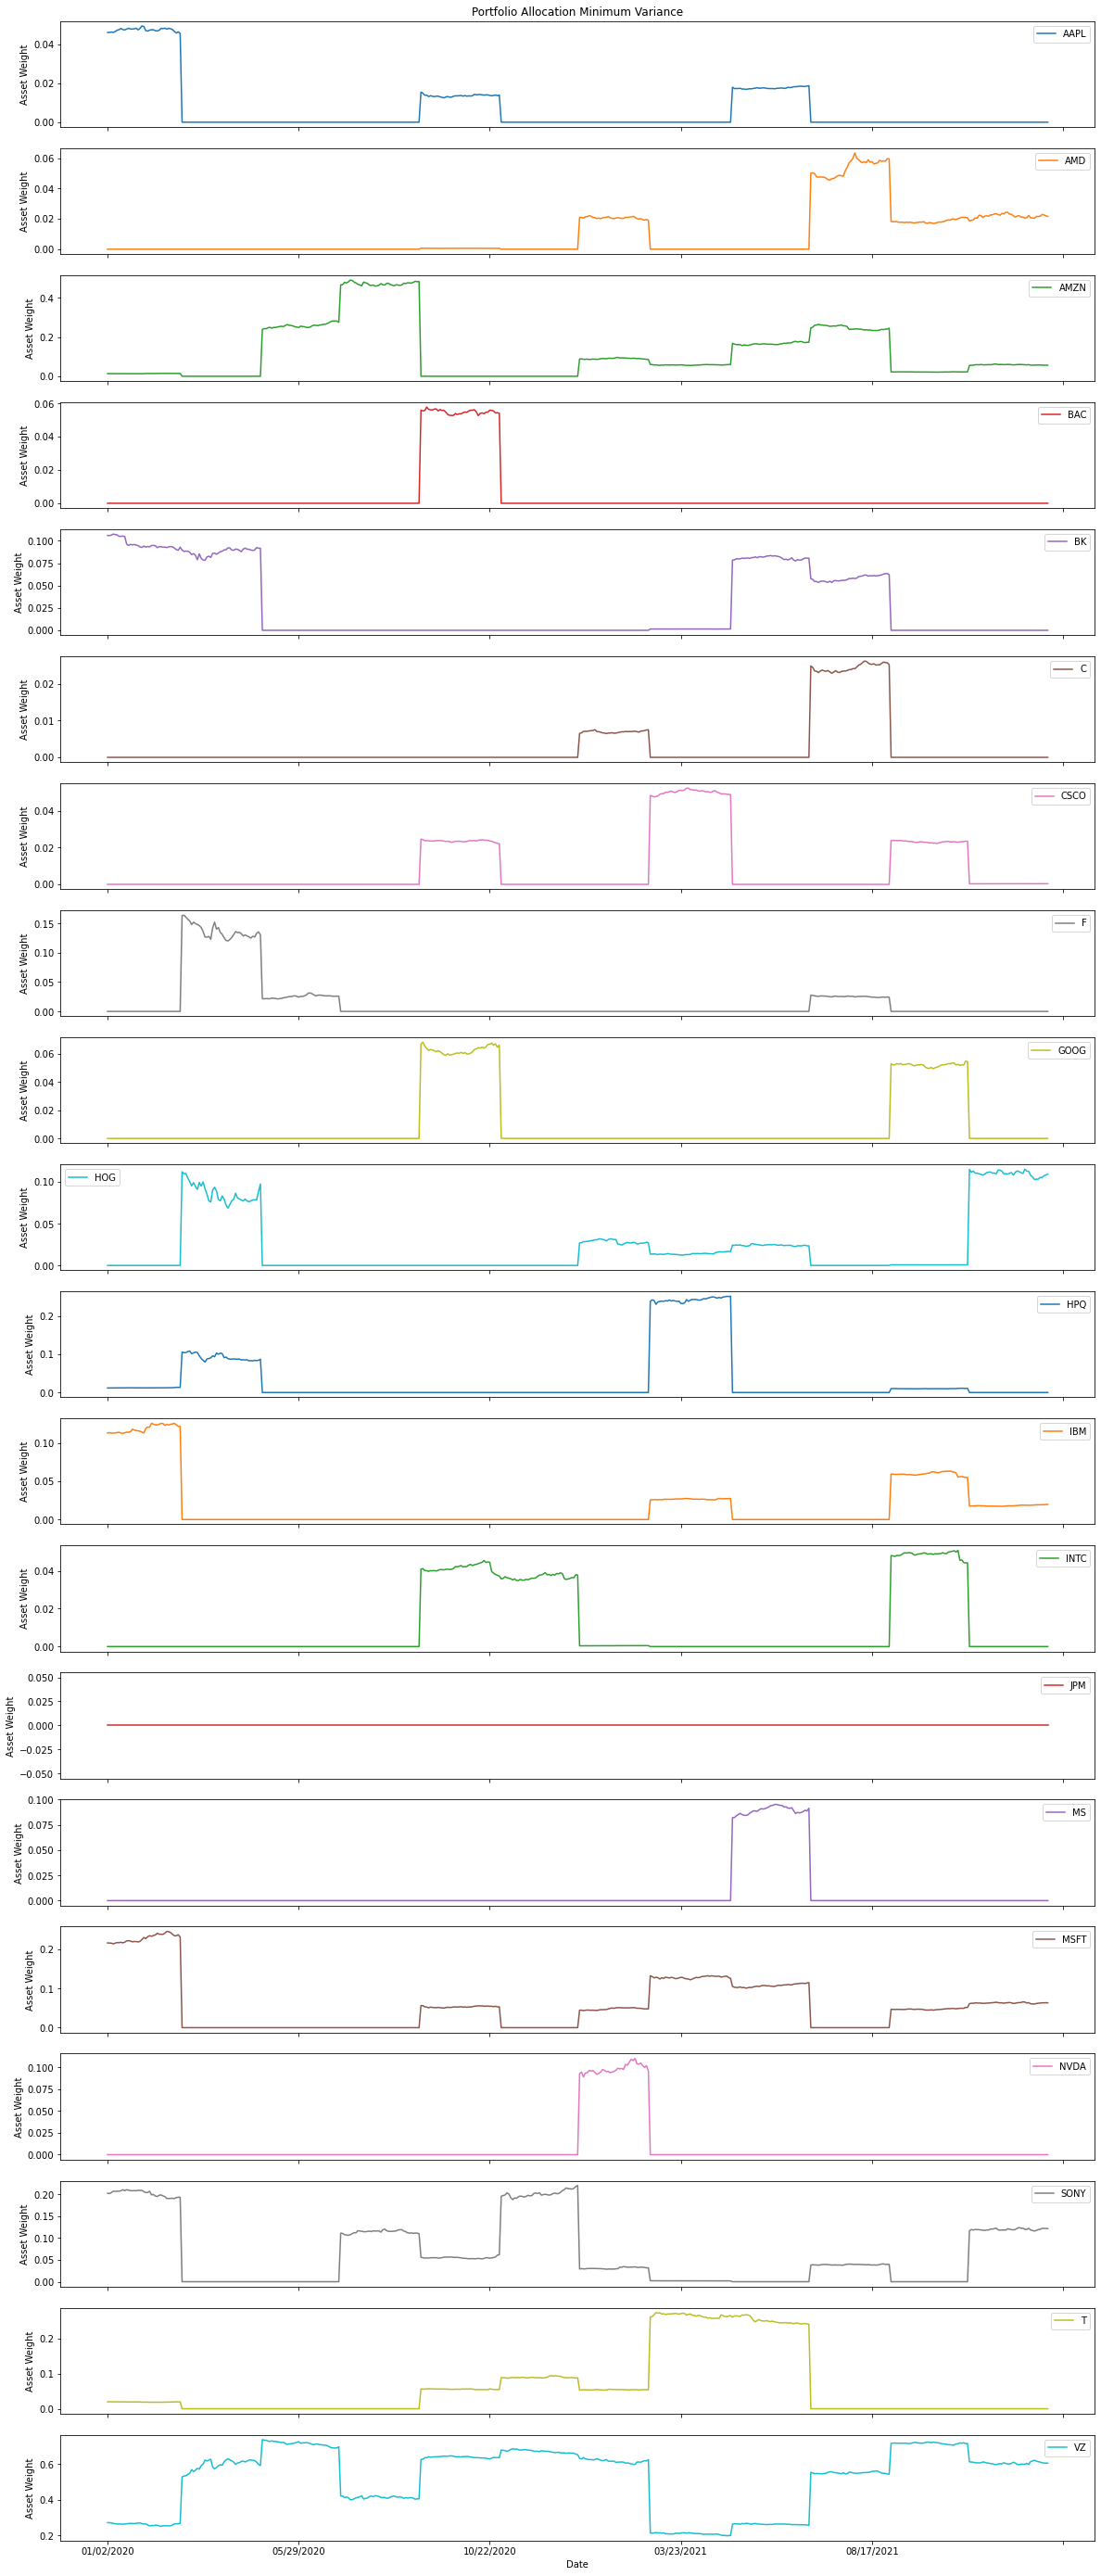

In [38]:
axes = da_valuedf3.plot.line(subplots=True,figsize = (20,50))
axes[0].set_title('Portfolio Allocation Minimum Variance')
axes[19].set_xlabel('Date')
for i in range(0,20):
    axes[i].set_ylabel('Asset Weight')

Text(0, 0.5, 'Asset Weights')

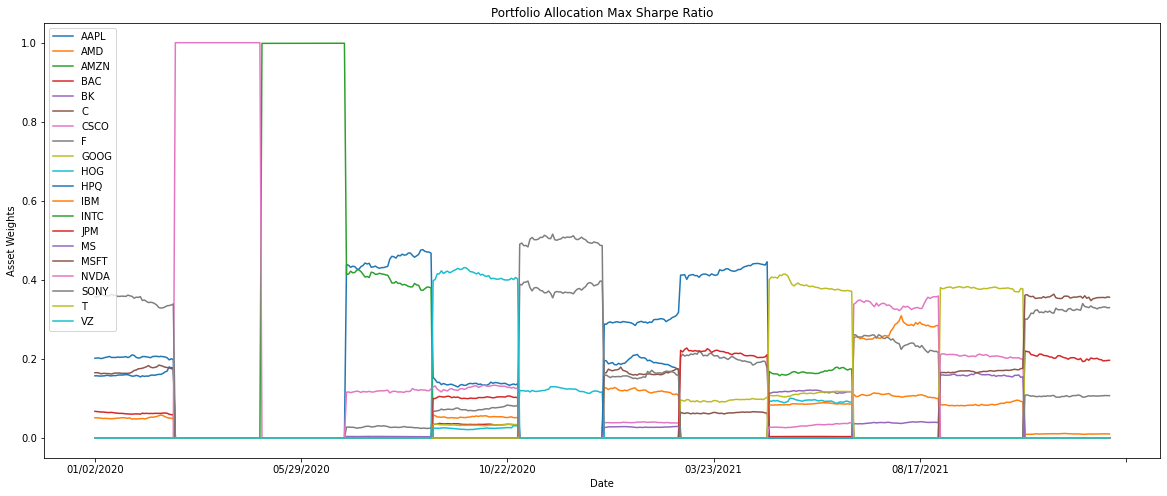

In [39]:
#ploting the chart showing Portfolio Allocation for Max Sharpe Ratio Strategy
da_valuedf4.plot.line(figsize = (20,8))
plt.title('Portfolio Allocation Max Sharpe Ratio')
plt.xlabel('Date')
plt.ylabel('Asset Weights')

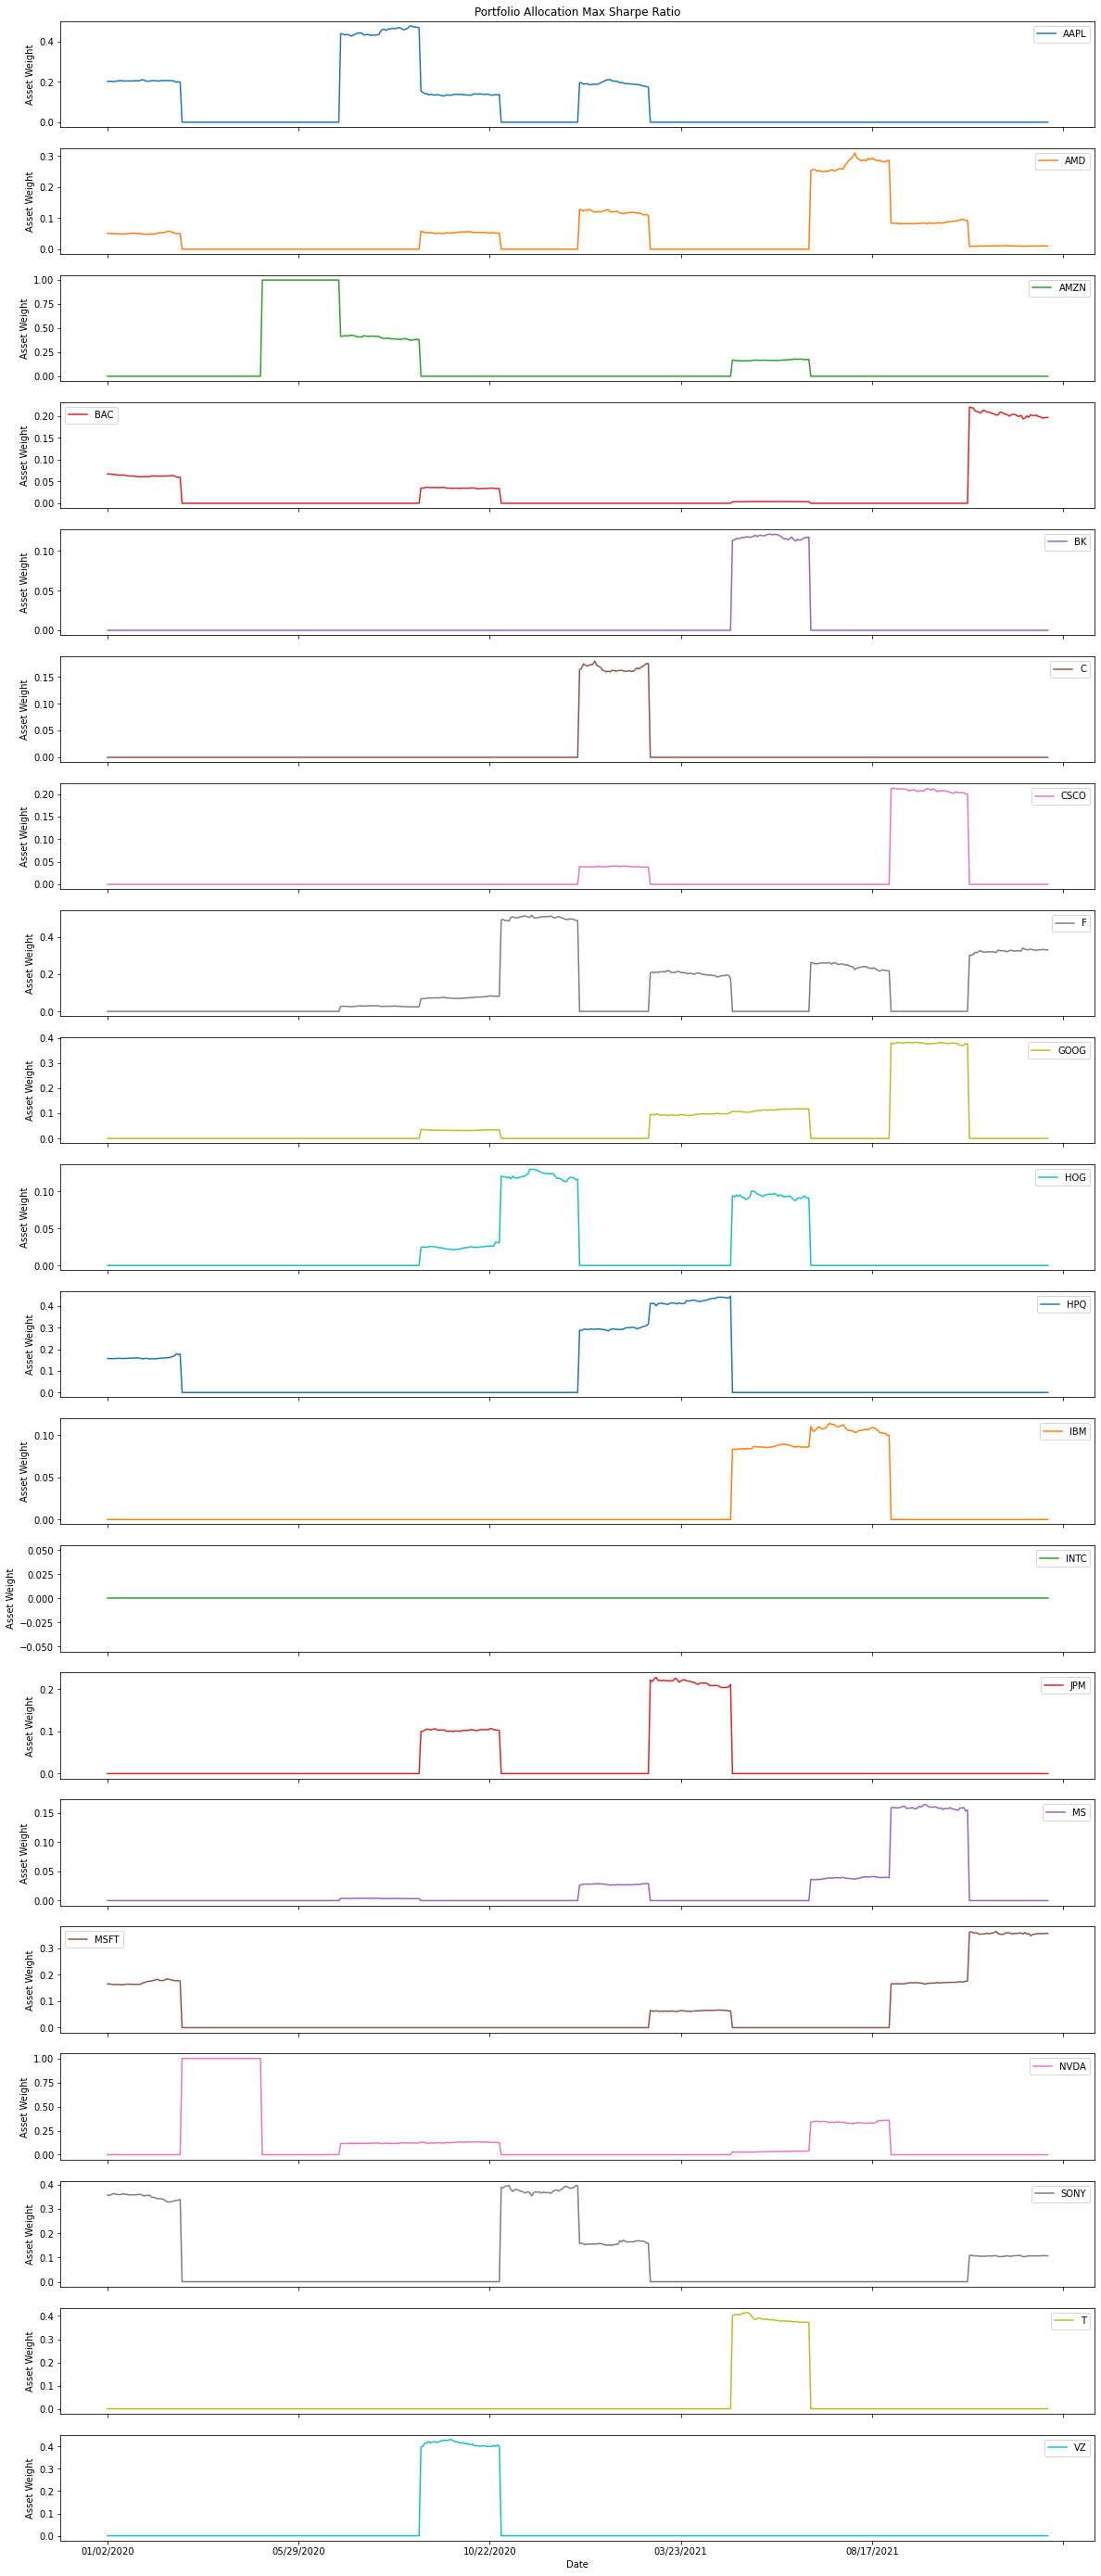

In [40]:
axes = da_valuedf4.plot.line(subplots=True,figsize = (20,50))
axes[0].set_title('Portfolio Allocation Max Sharpe Ratio')
axes[19].set_xlabel('Date')
for i in range(0,20):
    axes[i].set_ylabel('Asset Weight')